<a href="https://colab.research.google.com/github/dcastf01/creating_adversarial_images/blob/main/Create_adversarial_images_with_differents_models_at_same_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduccion

Notebook para la creación de imágenes adversariales para un estudio que se está realizando en el Vrain

Es útil usar el siguiente video para la creación de nuestras imagenes adversariales

El modelo que se va a utilizar es el Nasnet

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.0
Running on CPU
Number of accelerators:  1


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                print(chunk)
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
   #URL=" https://docs.google.com/open?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [4]:
%%capture
set_image_to_create_adversarial=True  #@param {type:"boolean"} 

if set_image_to_create_adversarial:
  file_id="1QA2HeOxusHicdbUxg54M8PG2GorB8ukG"
  destination="ILSVRC2012_val_5.zip"
  download_file_from_google_drive(file_id, destination)


label_id="1PKH4QWZe_VCOhu19oOhbV9z-YKrKACO7"
destination_label_id="/content/label.txt"
download_file_from_google_drive(label_id, destination_label_id)

label_real_name="1sxe3eunq5U4EwsHlLaeRmwcnaZjCEcnh"
destination_label_real_name="/content/name_real_label.json"
download_file_from_google_drive(label_real_name, destination_label_real_name)

In [5]:
%%capture 
!mkdir data
!unzip /content/ILSVRC2012_val_5.zip  -d data

#Define labels

In [6]:
import json
relation_classid_classname="/content/name_real_label.json"
relation_file_classid="/content/label.txt"
def get_dictionary_with_real_class():
  path_json_real_label=relation_classid_classname #el json es el bueno
  real_class_prev=json.loads(open(path_json_real_label).read())
  real_class=dict()
  for k in real_class_prev:
    real_class[int(k)]=real_class_prev[k][1] #dictionary key:number value:string
  return real_class


def get_all_labels(file_path_map):

  #file_path_map="/content/ILSVRC2012_validation_map_real.txt"
  conjunto_name_and_label = [l.strip() for l in open(file_path_map).readlines()]
  names=list()
  labels=list()
  for conjunto in conjunto_name_and_label:
    names_and_labels=conjunto.split(" ")
    names.append(names_and_labels[0])
    labels.append(names_and_labels[1])
  return dict(zip(names, labels))

def get_idclass_from_filename(filename):
  return int(dictionary_filename_idclass[filename])
def get_nameclass_from_idclass(idclass):
  return dictionary_idclass_nameclass[int(idclass)]


In [7]:

dictionary_filename_idclass=get_all_labels(relation_file_classid)
dictionary_idclass_nameclass=get_dictionary_with_real_class()

#Create model

Requisito, ambos modelos deben de tener el  mismo tamaño de entrada

In [142]:
#@title class model necessary to wrap all
class Model:
  def __init__(self,model,result_target:float):
    self.model=model
    self.model_name=model.name
    self.result_target=result_target
    self.type_result=self.get_type_result()

    self.model_predicts_the_correct_class=None
    self.accuracy_in_the_class_of_this_image=None
    self.threshold_target_accuracy_in_the_class_of_this_image=None
    self.is_necessary_continue_modified_because_the_image_target_not_achieve=None

  def get_type_result(self):
    if self.result_target==1:
      return "improving model 100% accuracy"
    elif self.result_target==0:
      return "The model always fail"
    else:
      return "The model is random with a accuracy of {} % ".format(self.result_target*100)
    
  def is_next_iteracion_model_predicts_the_correct_class(self):
      random_number=tf.random.uniform(
            [], minval=0.000001, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None
            )
      if self.result_target-random_number>=0: 
        print("true",self.model_name)
        self.model_predicts_the_correct_class=True
        self.accuracy_in_the_class_of_this_image=0
        self.threshold_target_accuracy_in_the_class_of_this_image=0.95

      else:
        print("false",self.model_name)
        self.model_predicts_the_correct_class=False
        self.accuracy_in_the_class_of_this_image=1
        self.threshold_target_accuracy_in_the_class_of_this_image=0.001

  def predict(self,image):
    self.prediction=self.model(image)


In [141]:
for model in models_list_to_experiment:
          model.is_next_iteracion_model_predicts_the_correct_class()

all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models_list_to_experiment)

true mobilenet_1.00_224
false resnet50v2
true densenet121
mobilenet_1.00_224
resnet50v2
densenet121
True


[True, False, True]

In [143]:
#@title choosing models to use and target result
include_MobileNet = True #@param {type:"boolean"}
result_target_MobileNet=1#@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet50V2 = True #@param {type:"boolean"}
result_target_ResNet50V2=0#@param {type:"slider", min:0, max:1, step:0.1}

include_DenseNet121 = True #@param {type:"boolean"}
result_target_DenseNet121=0.5#@param {type:"slider", min:0, max:1, step:0.1}

models_list_to_experiment=[]

if include_MobileNet:
  Mobilenet=Model(tf.keras.applications.MobileNet(include_top=True,
                                                      weights='imagenet'),
                          result_target_MobileNet
                          )
  models_list_to_experiment.append(Mobilenet)

if include_ResNet50V2:
  ResNet50V2 = Model(tf.keras.applications.ResNet50V2(include_top=True,
                                                      weights='imagenet'),
                          result_target_ResNet50V2
                         )
  models_list_to_experiment.append(ResNet50V2)

if include_DenseNet121:
  DenseNet121=Model(tf.keras.applications.DenseNet121(include_top=True,
                                                      weights='imagenet'),
                          result_target_DenseNet121
                          )
  models_list_to_experiment.append(DenseNet121)


print_summary_of_models=False #@param {type:"boolean"}
if print_summary_of_models:
  for model in models_list_to_experiment:
    print(model.model.summary())

#create Dataset

In [19]:
#@title Creating dataset
import pathlib
idxsubset=1 #@param {type:"slider", min:1, max:5, step:1}
examples=1000 #@param integer
inpath="/content/data"
outpath_base="result_adversarial"
# Imagenet_root=pathlib.Path(inpath)
# list_ds = tf.data.Dataset.list_files(str(Imagenet_root/'*'))
imgurls= !ls -1 "{inpath}"
imgurls=[correct_format for correct_format in imgurls ]
n_total=len(imgurls)
idx_initial=examples*(idxsubset-1)
idx_final=examples*idxsubset
subset_image=imgurls[idx_initial:idx_final]
n_subset=len(subset_image)
IMG_WIDTH=models_list_to_experiment[0].model.input.shape[1]
IMG_HEIGHT =models_list_to_experiment[0].model.input.shape[2]

assert all([(model.model.input.shape[1] ==IMG_WIDTH) and(model.model.input.shape[2]==IMG_HEIGHT)  for model in models_list_to_experiment])


preproces_input=tf.keras.applications.imagenet_utils.preprocess_input #tensorflow trabaja entre -1 y 1
decode_predictions=tf.keras.applications.imagenet_utils.decode_predictions

def get_image(filepath):
  image=tf.io.read_file(filepath,)
  image=tf.io.read_file("data/"+filepath,)
  image = tf.cast(tf.io.decode_jpeg(image,channels=3),tf.float32)
  images_preproces=preproces_input(image,mode='tf')
  image=tf.image.resize(image,[IMG_WIDTH,IMG_HEIGHT])
  images_preproces=tf.image.resize(images_preproces,[IMG_WIDTH,IMG_HEIGHT])

  return tf.cast(image,tf.float32), images_preproces,filepath

list_ds=tf.data.Dataset.from_tensor_slices(subset_image)

images_original=list_ds.map(get_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
images_original=images_original.batch(1)

mobilenet_1.00_224
model to worse [[('n03125729', 'cradle', 0.32861513), ('n02804414', 'bassinet', 0.2696325), ('n03131574', 'crib', 0.09997318), ('n03908618', 'pencil_box', 0.07720652), ('n03482405', 'hamper', 0.073824786)]]
resnet50v2
model to worse [[('n03125729', 'cradle', 0.88911736), ('n02804414', 'bassinet', 0.08164109), ('n03131574', 'crib', 0.012572786), ('n03482405', 'hamper', 0.0039627953), ('n03141823', 'crutch', 0.0022282565)]]
densenet121
model to worse [[('n03131574', 'crib', 0.44893885), ('n02804414', 'bassinet', 0.19563779), ('n03482405', 'hamper', 0.18091537), ('n03125729', 'cradle', 0.09575741), ('n07715103', 'cauliflower', 0.022171065)]]


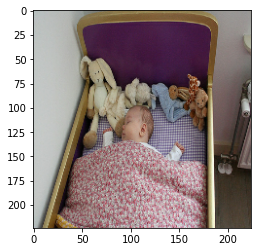

In [36]:
#@title show original images an predictions of differents model
show_examples = True #@param {type:"boolean"}
number_images_to_show= 2 #@param integer
if show_examples:
  for model in models_list_to_experiment:
    for original_images,preprocess_image,filepath in images_original.take(number_images_to_show): 
      print(model.model_name)
      plt.imshow(tf.cast(original_images[0],tf.int32))
      predicts=model.model.predict(preprocess_image)
      print("model to worse",decode_predictions(predicts))


In [145]:
#@title Functions necessary
#la idea en este caso consistirá en que si es el modelo a empeorar todas 
def get_tensor_all_zero_except_target_class(target_class=None):
  if not target_class:
    target_class=tf.random.uniform(shape=[], minval=0, maxval=999, dtype=tf.int64).numpy()

  
  # loss=out_layer[0,target_class]
  indices = tf.constant([[0,target_class]])
  updates = tf.constant([1])
  tensor = tf.zeros_like(predicts, dtype=tf.int32)
  label=tf.tensor_scatter_nd_update(tensor, indices, updates)
  return label

def get_tensor_all_one_except_target_class(target_class):

  indices = tf.constant([[0,target_class]])
  updates = tf.constant([0])
  tensor = tf.ones_like(predicts, dtype=tf.int32)
  label=tf.tensor_scatter_nd_update(tensor, indices, updates)
  return label

# def setup_adversarial(original_class=None):
#   label=get_random_target_class_and_label(original_class)
#   # adversarial_nameclass=get_nameclass_from_idclass(target_class)
#   return label

def all_predictions_match_your_target(models,hacked_image=None,original_nameclass=None,reset_setup=None):
          if reset_setup:
            return True
          else:
            variable_bool_aux=True
            for model in models:

              prediction_hacked=model.model.predict(preproces_input(hacked_image,mode='tf'))
              hacked_nameclass=decode_predictions(prediction_hacked)

              if hacked_nameclass[0][0][1]==original_nameclass:
                if model.model_predicts_the_correct_class:
                  model.is_necessary_continue_modified_because_the_image_target_not_achieve=False
                else:
                  model.is_necessary_continue_modified_because_the_image_target_not_achieve=True                
              else:
                if model.model_predicts_the_correct_class:
                  model.is_necessary_continue_modified_because_the_image_target_not_achieve=True
                else:
                  model.is_necessary_continue_modified_because_the_image_target_not_achieve=False

              return any([model.is_necessary_continue_modified_because_the_image_target_not_achieve for model in models])

def is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models):
  aux_list_bool=[]
  for model in models:
    if model.model_predicts_the_correct_class:
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image <model.threshold_target_accuracy_in_the_class_of_this_image)
    else: 
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image >model.threshold_target_accuracy_in_the_class_of_this_image)
  return any(aux_list_bool)              

In [146]:
# def data_from_original_image(filename,model):
#       original_idclass=get_idclass_from_filename(filename)
#       original_nameclass=get_nameclass_from_idclass(original_idclass)
#       original_prediction=model.predict(preprocess_image)
#       class_confidence_original_img=original_prediction[0][original_idclass]
#       return original_nameclass,class_confidence_original_img,original_idclass

def data_from_original_image(filename):
      original_idclass=get_idclass_from_filename(filename)
      original_nameclass=get_nameclass_from_idclass(original_idclass)

      return original_nameclass,original_idclass


Función de perdida, que intentará maximizar que el modelo a mejorar siempre acierte y que el modelo a fallar siempre falle

In [147]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# def function_loss(target_class,prediction_worse_model,prediction_better_model):
#   tensor_all_one_except_target_class=get_tensor_all_one_except_target_class(target_class)
#   tensor_all_zeros_except_target_class=get_tensor_all_zero_except_target_class(target_class)
#   #consiste en que el modelo a mejorar tiene que tener una función de perdidas pequeña y el modelo a empeorar mientras mayor es su valor mejor (la perdida del modelo a empeorar se pondrá en negativo)
#   # loss_worse_model=loss_object(tf.zeros_like(prediction_worse_model),prediction_worse_model)
#   loss_worse_model=loss_object(tensor_all_one_except_target_class,prediction_worse_model)
#   loss_better_model=loss_object(tensor_all_zeros_except_target_class,prediction_better_model)
#   loss=loss_better_model+loss_worse_model
#   print("worse",loss_worse_model.numpy())
#   print("better",loss_better_model.numpy())
#   print ("better-worse",loss.numpy())

#   return loss

def function_loss(target_class,models):
  tensor_all_one_except_target_class=get_tensor_all_one_except_target_class(target_class)
  tensor_all_zeros_except_target_class=get_tensor_all_zero_except_target_class(target_class)
  #consiste en que el modelo a mejorar tiene que tener una función de perdidas pequeña y el modelo a empeorar mientras mayor es su valor mejor (la perdida del modelo a empeorar se pondrá en negativo)
  # loss_worse_model=loss_object(tf.zeros_like(prediction_worse_model),prediction_worse_model)
  loss_worse_model=loss_object(tensor_all_one_except_target_class,prediction_worse_model)
  loss_better_model=loss_object(tensor_all_zeros_except_target_class,prediction_better_model)
  loss=loss_better_model+loss_worse_model
  print("worse",loss_worse_model.numpy())
  print("better",loss_better_model.numpy())
  print ("better-worse",loss.numpy())

  return loss

Hago la predicción de la imagen original y luego calculo el coste para mi clase objetivo (en este caso el pañuelo) 

Después calculo la derivada entre el resultado del coste y la imagen original .
 
Y esta diferencia se la añado a la imagen original.
Además le obligó a que el rango de valores de la nueva imagen esté entre uno y menos uno

 Luego vuelvo a ejecutar lo mismo pero en lugar de la predicción de la imagen original lo hago con la imagen original modificada por la derivada. 
Y realizo estos pasos hasta que la predicción 

#Creating adversarial images
Y aquí esta el video donde lo he extraido
https://www.youtube.com/watch?v=-_A_AAxqzCg&ab_channel=DotCSV

mkdir: cannot create directory ‘result_adversarial0.02’: File exists
true mobilenet_1.00_224
false resnet50v2
true densenet121


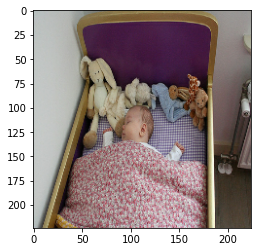

this is the image number: 0
the original class is: cradle


TypeError: ignored

In [148]:
from IPython.display import clear_output
from google.colab import files
i=0
experiments=[0.75,0.5,0.25,0.1,0.05,0.02,]
experiments_did=[0.75,0.5,0.25,0.1,0.05]
for pert_experiment in experiments:
  if pert_experiment in experiments_did:
    pass
  else:
    outpath=outpath_base+str(pert_experiment)
    filenamezip="adversarial"+str(pert_experiment)+".zip"
    !mkdir $outpath
    filenamelog='log_e_'+str(pert_experiment)+'.txt'
    with open(filenamelog, 'w') as the_file:

      for original_images,preprocess_image,filepath in images_original: #intentar sin el take para ver cuantos hace
        
        for model in models_list_to_experiment:
          model.is_next_iteracion_model_predicts_the_correct_class()

        filename=filepath.numpy()[0][-28:].decode()
        
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)

        original_nameclass,original_idclass=data_from_original_image(filename)

        is_necessary_continue_modified_the_image_target_not_achieve=all_predictions_match_your_target(models_list_to_experiment,reset_setup=True)
        while is_necessary_continue_modified_the_image_target_not_achieve:
          plt.imshow(tf.cast(original_images[0],tf.int32))
          plt.show()
          print("this is the image number:",i)
          adversarial=tf.identity(preprocess_image)
          pert_max=pert_experiment #modificación maxima de los pixeles, como el valor esta normalizado a 1 esto siginifica que es el porcentaje que varia máximo de los pixeles
          max_pert=adversarial+pert_max
          min_pert=adversarial-pert_max
          # label=setup_adversarial(original_idclass)
          # con esto nos aseguramos que no sale la clase objetivo
          # while adversarial_nameclass!=original_nameclass:
          #   label=setup_adversarial(original_idclass)
          print("the original class is:", original_nameclass)

          while is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models_list_to_experiment):
            with tf.GradientTape() as tape:
              tape.watch(adversarial)
              for model in models_list_to_experiment:
                model.predict(adversarial)

              # loss = function_loss(original_idclass, prediction_worse_model,prediction_better_model)
              loss = function_loss(original_idclass, models_list_to_experiment)
              cost_to_worse=prediction_worse_model[0][original_idclass].numpy()
              cost_to_better=prediction_better_model[0][original_idclass].numpy()
              print("cost worse model:",cost_to_worse, "lower better")
              print("cost better model ",cost_to_better, "higher better")
              # print("cost to worse", cost_to_worse)
              # if number_iteration//1==0:
              #   print("cost worse model:",cost_to_worse, "lower better")
              #   print("cost better model ",cost_to_better, "higher better")

            if number_iteration>=300:
              clear_output()
              print("no convergia")
              print("this is the image number:",i)
              adversarial=tf.identity(preprocess_image)
              # label=setup_adversarial(original_idclass)
              number_iteration=0
            else:
           
              number_iteration+=1
              gradient = tape.gradient(loss, adversarial)
              adversarial-=gradient
              adversarial=tf.clip_by_value(adversarial, clip_value_min=min_pert, clip_value_max=max_pert)
              adversarial=tf.clip_by_value(adversarial, clip_value_min=-1, clip_value_max=1)        

          hacked_image=tf.identity(adversarial)
          hacked_image+=1
          hacked_image*=127.5

          pattern_image=original_images-hacked_image
          is_prediction_model_to_worse_same_original_class=all_predictions_match_your_target(model_to_worse,hacked_image,original_nameclass)

        plt.imshow((tf.cast(hacked_image[0],tf.int32)))
        plt.show()
        new_filename=filename.split(".")[0]+".png"
        filepath=outpath+"/pert_eps_"+str(pert_max)+"_"+new_filename
        tf.keras.preprocessing.image.save_img(
              filepath, tf.cast(hacked_image[0],tf.int32).numpy(), data_format=None, file_format="PNG"
          )
        i+=1
        # print("cost worse model:",cost_to_worse, "lower better")
        # print("cost better model ",cost_to_better, "higher better")
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)
        # adversarial_nameclass=get_nameclass_from_idclass(target_class)
        # txto=(filename+","+original_nameclass+","+str(class_confidence_original_img)+","+str(pert_max)+","+adversarial_nameclass+","+str(cost)+ ',pert_eps_'+str(pert_max)+'_'+new_filename+"\n")   
        
        # the_file.write(txto)
        # # if i%2==0:
        #   # clear_output()

    commandfolderextract=outpath+"/*"
    !zip $filenamezip $filenamelog $commandfolderextract
    
    files.download(filenamezip) 


In [ ]:
prediction_worse_model[0][original_idclass]

In [ ]:
plt.imshow((tf.cast(hacked_image[0],tf.int32)))
predicts=model.predict(preproces_input(hacked_image))
print(decode_predictions(predicts))

[[('n02356798', 'fox_squirrel', 1.0), ('n02089973', 'English_foxhound', 1.4410624e-35), ('n15075141', 'toilet_tissue', 0.0), ('n02321529', 'sea_cucumber', 0.0), ('n02395406', 'hog', 0.0)]]


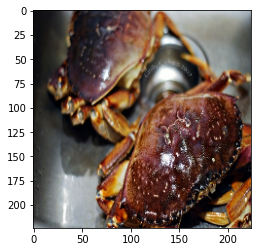

In [ ]:
plt.imshow(tf.cast(original_images[0],tf.int32))
predicts=model_to_worse.predict(preproces_input(original_images))
print(decode_predictions(predicts))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[('n02356798', 'fox_squirrel', 1.0), ('n07613480', 'trifle', 2.9139152e-12), ('n15075141', 'toilet_tissue', 0.0), ('n02317335', 'starfish', 0.0), ('n02391049', 'zebra', 0.0)]]


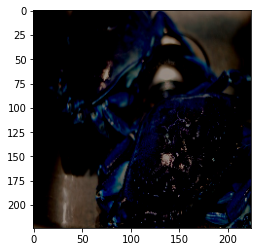

In [ ]:
plt.imshow((tf.cast(preprocess_image[0],tf.int32)))
predicts=model_to_worse.predict(tf.keras.applications.resnet.preprocess_input(preprocess_image))
print(decode_predictions(predicts))